# 라이브러리 import

In [183]:
import datetime as dt
import time
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

# 데이터 로드

In [184]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [185]:
# user 수
data['UserId'].nunique()

6040

In [186]:
# item 수
data['ItemId'].nunique()

3706

# 데이터 전처리

In [187]:
# user 당 몇 번의 영화평가를 남겼는지 체크 
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [188]:
# user들의 영화평가 횟수 중앙값
user_length.median()

96.0

In [189]:
# user들의 영화평가 횟수 평균
user_length.mean()

165.5975165562914

In [190]:
# user 영화평가 최저 횟수
user_length.min()

20

In [191]:
# user 영화평가 최대 횟수
user_length.max()

2314

In [192]:
# 99.9%의 user들의 영화평가 횟수
user_length.quantile(0.999)

1343.181000000005

In [194]:
# 1343.2 회 이상 평가를 남긴 유저 확인
long_user = user_length[user_length > 1343.18]
long_user

UserId
889     1518
1181    1521
1680    1850
1941    1595
3618    1344
4169    2314
4277    1743
dtype: int64

### 이 결과로 7 명의 유저가 1343.2회 이상 영화평가를 남긴 것을 알 수 있었다.

## 유저 길이 기준 하위 99.9%까지의 분포 누적합을 시각화

In [195]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

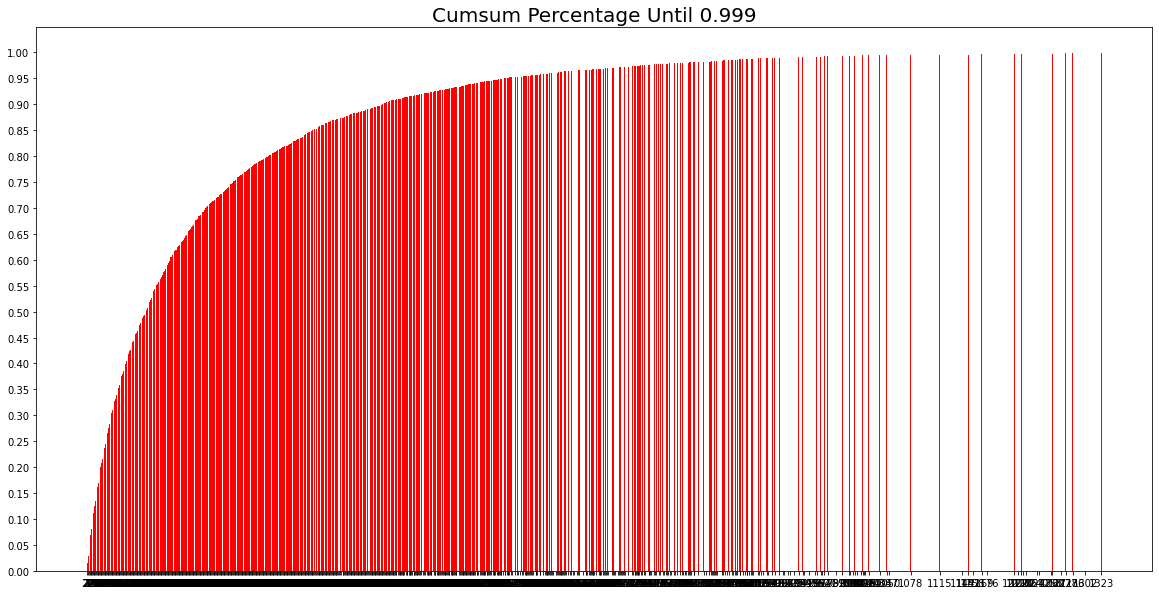

In [196]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## user들이 영화평가를 남긴 시간에 대한 정리

In [197]:
# 가장 오래된 평가와 최근 평가
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [198]:
type(latest)

numpy.int64

In [199]:
# timestamp 형식으로 되어있으므로 datetime으로 형변환
oldest_time = dt.datetime.fromtimestamp(oldest)
print(oldest_time)

2000-04-25 23:05:32


In [200]:
# timestamp 형식으로 되어있으므로 datetime으로 형변환
latest_time = dt.datetime.fromtimestamp(latest)
print(latest_time)

2003-02-28 17:49:50


### 이 정보를 통해 2000년 4월 25일부터 2003년 2월 28일까지 약 3년 (34개월) 간의 데이터가 있음을 확인하였다.

## 영화 선택은 짧은 시간에 바뀌지 않는 개인의 취향이기 때문에 긴 시간의 데이터를 사용하기로 결정하였다.

In [233]:
# 최종 날짜로부터 1000일 이전의 timestamp를 찾음
time_ago = latest_time - dt.timedelta(1000)
time_ago_timestamp = int(time.mktime(time_ago.timetuple()))
time_ago_timestamp

960054590

In [202]:
# 최종 날짜로부터 1000일 이전의 데이터만 구함
temp_data = data[data['Time'] > time_ago_timestamp]
cropped_data = temp_data.reset_index(drop=True)
cropped_data

,UserId,ItemId,Rating,Time
0,1,3186,4,978300019
1,1,1270,5,978300055
2,1,1721,4,978300055
3,1,1022,5,978300055
4,1,2340,3,978300103
...,...,...,...,...
913130,6040,2917,4,997454429
913131,6040,1921,4,997454464
913132,6040,1784,3,997454464
913133,6040,161,3,997454486


# data cleansing

### 20개 이상의 영화를 본 사람과 최소 5명 이상의 사람이 본 영화만을 남긴다. (가장 적은 영화 평가를 남긴 사람이 20개이므로 조절 가능)

In [234]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 'shortest' 보다 작은 session이 생길 수 있다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_watch) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_watch)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_watch):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_watch].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [235]:
cleaned_data = cleanse_recursive(cropped_data, shortest=20, least_watch=5)
len(cleaned_data)

912020

# train / val / test 데이터 분리

In [236]:
# data에서 시간이 timestamp로 되어있기 때문에 최근일을 기준으로 찾는 형식으로 했다. 
def split_by_date(data: pd.DataFrame, n_days: int):
    # 최종 날짜로부터 n일 이전의 timestamp를 찾음
    n_days_ago = latest_time - dt.timedelta(n_days)
    n_days_ago_timestamp = int(time.mktime(n_days_ago.timetuple()))
    
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < n_days_ago_timestamp].index
    session_in_test = session_last_time[session_last_time >= n_days_ago_timestamp].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [261]:
# train : val : test = 6 : 2 : 2 정도의 비율로 하기 위해 설정했다
tr, test = split_by_date(cleaned_data, n_days=350)
tr, val = split_by_date(tr, n_days=800)

In [262]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [263]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 550892
	 Users: 4234
	 Items: 3396
	 First Time : 960055528
	 Last Time : 977294538

* valid Set Stats Info
	 Events: 184010
	 Users: 833
	 Items: 3328
	 First Time : 960075689
	 Last Time : 1016198312

* test Set Stats Info
	 Events: 177089
	 Users: 478
	 Items: 3363
	 First Time : 960054593
	 Last Time : 1046454590



In [266]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [267]:
len(tr), len(val), len(test)

(550892, 184010, 177089)

In [268]:
# 데이터 저장
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 미니배치 구성

In [269]:
# 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스 생성
class SessionDataset:
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each User IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [270]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
21004,152,839,4,977268684,0
21005,152,2279,2,977268702,1
21006,152,1721,1,977268731,2
21007,152,10,4,977268731,3
21008,152,1753,5,977268750,4
21009,152,1968,5,977268750,5
21010,152,3114,4,977268843,6
21011,152,3255,4,977268843,7
21012,152,2804,4,977268843,8
21013,152,180,5,977268843,9


In [271]:
# 각 세션이 시작된 인덱스
tr_dataset.click_offsets

array([     0,     24,     68, ..., 550604, 550865, 550892], dtype=int32)

In [272]:
# 각 세션을 인덱싱한 np.array
tr_dataset.session_idx

array([   0,    1,    2, ..., 4231, 4232, 4233])

In [273]:
# SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스
class SessionDataLoader:
    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [274]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
21004,152,839,4,977268684,0
21005,152,2279,2,977268702,1
21006,152,1721,1,977268731,2
21007,152,10,4,977268731,3
21008,152,1753,5,977268750,4
21009,152,1968,5,977268750,5
21010,152,3114,4,977268843,6
21011,152,3255,4,977268843,7
21012,152,2804,4,977268843,8
21013,152,180,5,977268843,9


In [275]:
iter_ex = iter(tr_data_loader)

In [276]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  24  65 156]
Label Item Idx are :       [  1  25  25 157]
Previous Masked Input Idx are []


# 모델 구성

In [277]:
# 평가 지표로 순서에 민감한 지표인 MRR외 recall의 개념을 확장한 Recall@k 사용
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [278]:
# 모델 구조 정의
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [279]:
# 모델에서 사용할 하이퍼 파라미터 정의
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [280]:
# 모델 생성
model = create_model(args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(128, 1, 3396)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    517200    
_________________________________________________________________
dropout_5 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (128, 3396)               173196    
Total params: 690,396
Trainable params: 690,396
Non-trainable params: 0
_________________________________________________________________


# 모델 학습

In [281]:
# train 데이터로 학습, val 데이터로 검증
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # val 검증

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옴
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter 가져옴
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter 초기화
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid / test 평가 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [282]:
# 모델 학습
train_model(model, args)

Train:   0%|          | 0/4270 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.26] 

	 - Recall@20 epoch 1: 0.166074
	 - MRR@20    epoch 1: 0.039628



Train:   0%|          | 0/4270 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.71] 

	 - Recall@20 epoch 2: 0.248492
	 - MRR@20    epoch 2: 0.064779



Evaluation:  87%|████████▋ | 1243/1431 [17:41<02:40,  1.17it/s]

	 - Recall@20 epoch 3: 0.282633
	 - MRR@20    epoch 3: 0.077990



## 모델 테스트

In [283]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  82%|████████▏ | 1128/1379 [16:33<03:41,  1.13it/s]

	 - Recall@20: 0.234257
	 - MRR@20: 0.063089



### 학습에 소요되는 시간이 길기 때문에 두번째 시도에서는 모델의 하이퍼 파라미터를 조절하여 첫번째 시도와 비교할 예정이고, 이때 찾은 하이퍼 파라미터를 사용해 세번째 시도에서는 데이터 전처리 과정을 변형하고 학습을 진행해보려고 한다.

# 2nd Try

In [284]:
# 모델에서 사용할 하이퍼 파라미터 변경
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args2 = Args(tr, val, test, batch_size=256, hsz=30, drop_rate=0.5, lr=0.001, epochs=10, k=20)

In [285]:
# 모델 생성
model2 = create_model(args2)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(256, 1, 3396)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 30), (256, 30)]    308520    
_________________________________________________________________
dropout_6 (Dropout)          (256, 30)                 0         
_________________________________________________________________
dense_6 (Dense)              (256, 3396)               105276    
Total params: 413,796
Trainable params: 413,796
Non-trainable params: 0
_________________________________________________________________


In [286]:
# 모델 학습
train_model(model2, args2)

Train:   0%|          | 0/2135 [00:00<?, ?it/s, accuracy=0.0234, train_loss=7.16] 

	 - Recall@20 epoch 1: 0.066864
	 - MRR@20    epoch 1: 0.013575



Train:   0%|          | 0/2135 [00:00<?, ?it/s, accuracy=0, train_loss=7.13]      

	 - Recall@20 epoch 2: 0.111279
	 - MRR@20    epoch 2: 0.024617



Train:   0%|          | 0/2135 [00:00<?, ?it/s, accuracy=0.0273, train_loss=6.76] 

	 - Recall@20 epoch 3: 0.174852
	 - MRR@20    epoch 3: 0.041374



Train:   0%|          | 0/2135 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.62] 

	 - Recall@20 epoch 4: 0.214634
	 - MRR@20    epoch 4: 0.053155



Train:   0%|          | 0/2135 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.51] 

	 - Recall@20 epoch 5: 0.243125
	 - MRR@20    epoch 5: 0.061360



Train:   0%|          | 0/2135 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.96] 

	 - Recall@20 epoch 6: 0.260144
	 - MRR@20    epoch 6: 0.067224



Train:   0%|          | 0/2135 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.44] 

	 - Recall@20 epoch 7: 0.271848
	 - MRR@20    epoch 7: 0.071096



Train:   0%|          | 0/2135 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.36] 

	 - Recall@20 epoch 8: 0.280448
	 - MRR@20    epoch 8: 0.074318



Train:   0%|          | 0/2135 [00:00<?, ?it/s, accuracy=0.0508, train_loss=6.3]  

	 - Recall@20 epoch 9: 0.287758
	 - MRR@20    epoch 9: 0.077470



Evaluation:  73%|███████▎  | 521/715 [14:24<05:21,  1.66s/it]

	 - Recall@20 epoch 10: 0.292264
	 - MRR@20    epoch 10: 0.079057



In [287]:
# 모델 테스트
test_model(model2, args2, test)

Evaluation:  59%|█████▉    | 409/689 [11:35<07:55,  1.70s/it]

	 - Recall@20: 0.256265
	 - MRR@20: 0.067813



첫번째 시도보다 조금 더 높은 정확도를 보였지만 epoch수와 시간을 감안하면 상당히 비효율적이고, 오히려 첫번째 시도와 같은 하이퍼파라미터에 epoch수를 증가시키는 것이 효율적이라고 판단하였다.

# 3rd Try

별점이 영화선택에 큰 영향을 줄 것이라고 판단하여 별점이 기준 이하인 경우 데이터에서 제거하기로 결정했다.

In [288]:
# 별점 3이하 제거
rating_4_data = cropped_data[cropped_data['Rating']>3]
len(rating_4_data)

524101

In [289]:
# 별점 2이하 제거
rating_3_data = cropped_data[cropped_data['Rating']>2]
len(rating_3_data)

763367

별점 3개 이하를 제거한 경우 데이터의 수가 반정도로 줄어들어서 별점 2개 이하만 지우기로 결정했다.

이전까지는 유저의 99.9%가 분포한 범위 내에서 데이터를 사용했는데, 누적분포에서 적은 부분을 차지하는 앞부분을 제거하여 많은 유저들이 분포하는 범위인 데이터를 사용하여 학습을 진행해보려고 한다. 그래서 유저와 아이템 모두 하위 20% 이상인 데이터만 사용하기로 결정했다.

In [299]:
# 유저 길이의 분포 누적합 확인
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999.head(20)

20    0.014238
21    0.029305
22    0.042053
23    0.055464
24    0.068874
25    0.081291
26    0.091556
27    0.102483
28    0.112417
29    0.124338
30    0.133940
31    0.142384
32    0.151490
33    0.161755
34    0.169040
35    0.178642
36    0.190397
37    0.199503
38    0.207616
39    0.215728
dtype: float64

In [300]:
# item 당 몇 명의 사람들이 봤는지 체크 
item_length = cropped_data.groupby('ItemId').size()
item_length

ItemId
1       1878
2        638
3        449
4        146
5        265
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3701, dtype: int64

In [303]:
# 아이템 시청 인원 길이의 분포 누적합 확인
item_length_count = item_length.groupby(item_length).size()
item_length_percent_cumsum = item_length_count.cumsum() / item_length_count.sum()
item_length_percent_cumsum_999 = item_length_percent_cumsum[item_length_percent_cumsum < 0.999]

item_length_percent_cumsum_999.head(25)

1     0.033234
2     0.055120
3     0.067009
4     0.079708
5     0.089976
6     0.099162
7     0.107268
8     0.116455
9     0.124831
10    0.131316
11    0.139962
12    0.145907
13    0.153202
14    0.157255
15    0.162659
16    0.168603
17    0.174277
18    0.180762
19    0.188057
20    0.192921
21    0.198055
22    0.205080
23    0.209403
24    0.216428
25    0.220211
dtype: float64

In [304]:
# 38개 이상의 영화를 본 사람과 최소 22명 이상의 사람이 본 영화만을 남김
cleaned_data2 = cleanse_recursive(cropped_data, shortest=38, least_watch=22)
len(cleaned_data2)

875266

In [313]:
# train : val : test = 6 : 2 : 2 정도의 비율로 하기 위해 설정했다
tr2, test2 = split_by_date(cleaned_data2, n_days=300)
tr2, val2 = split_by_date(tr2, n_days=770)

In [314]:
stats_info(tr2, 'train')
stats_info(val2, 'valid')
stats_info(test2, 'test')

* train Set Stats Info
	 Events: 553220
	 Users: 3387
	 Items: 2953
	 First Time : 960055528
	 Last Time : 979918771

* valid Set Stats Info
	 Events: 157056
	 Users: 599
	 Items: 2951
	 First Time : 960075689
	 Last Time : 1020462626

* test Set Stats Info
	 Events: 164980
	 Users: 428
	 Items: 2953
	 First Time : 960054593
	 Last Time : 1046454590



In [315]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx2 = {item_id : index for index, item_id in enumerate(tr2['ItemId'].unique())}

tr2 = indexing(tr2, id2idx2)
val2 = indexing(val2, id2idx2)
test2 = indexing(test2, id2idx2)

In [316]:
len(tr2), len(val2), len(test2)

(553220, 157056, 164980)

In [317]:
# 데이터 저장
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr2.to_pickle(save_path / 'train2.pkl')
val2.to_pickle(save_path / 'valid2.pkl')
test2.to_pickle(save_path / 'test2.pkl')

In [318]:
# 미니배치 구성
tr_dataset2 = SessionDataset(tr2)
tr_dataset2.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,2
3,1,1022,5,978300055,3
4,1,2340,3,978300103,4
5,1,1836,5,978300172,5
6,1,3408,4,978300275,6
7,1,2804,5,978300719,7
8,1,1207,4,978300719,8
9,1,1193,5,978300760,9


In [319]:
tr_data_loader2 = SessionDataLoader(tr_dataset2, batch_size=4)
tr_dataset2.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,2
3,1,1022,5,978300055,3
4,1,2340,3,978300103,4
5,1,1836,5,978300172,5
6,1,3408,4,978300275,6
7,1,2804,5,978300719,7
8,1,1207,4,978300719,8
9,1,1193,5,978300760,9


In [320]:
iter_ex2 = iter(tr_data_loader2)

In [321]:
inputs2, labels2, mask2 =  next(iter_ex2)
print(f'Model Input Item Idx are : {inputs2}')
print(f'Label Item Idx are : {"":5} {labels2}')
print(f'Previous Masked Input Idx are {mask2}')

Model Input Item Idx are : [ 0 53 65 56]
Label Item Idx are :       [  1  54  62 208]
Previous Masked Input Idx are []


In [322]:
# 모델에서 사용할 하이퍼 파라미터 변경
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args3 = Args(tr2, val2, test2, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [323]:
# 모델 생성
model3 = create_model(args3)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(128, 1, 2953)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    450750    
_________________________________________________________________
dropout_7 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_7 (Dense)              (128, 2953)               150603    
Total params: 601,353
Trainable params: 601,353
Non-trainable params: 0
_________________________________________________________________


In [324]:
# 모델 학습
train_model(model3, args3)

Train:   0%|          | 0/4295 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.24] 

	 - Recall@20 epoch 1: 0.166796
	 - MRR@20    epoch 1: 0.039632



Train:   0%|          | 0/4295 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.61] 

	 - Recall@20 epoch 2: 0.247267
	 - MRR@20    epoch 2: 0.064687



Train:   0%|          | 0/4295 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.41] 

	 - Recall@20 epoch 3: 0.278145
	 - MRR@20    epoch 3: 0.077989



Train:   0%|          | 0/4295 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.35] 

	 - Recall@20 epoch 4: 0.296602
	 - MRR@20    epoch 4: 0.086237



Evaluation:  84%|████████▍ | 1029/1222 [16:53<03:10,  1.02it/s]

	 - Recall@20 epoch 5: 0.306472
	 - MRR@20    epoch 5: 0.090741



In [325]:
# 모델 테스트
test_model(model3, args3, test2)

Evaluation:  80%|███████▉  | 1026/1285 [17:31<04:25,  1.02s/it]

	 - Recall@20: 0.265762
	 - MRR@20: 0.076481



# 결론

첫번째와 세번째의 학습 정보들이 거의 비슷하기 때문에 세번째 시도에서 적용한 인원과 아이템 하위 20%이상과 별점의 역할은 미미하다는 것을 알 수 있었다. 따라서 주어진 조건에서는 epoch 수를 늘리면 더 좋은 결과를 얻을 것이라고 예상된다.

# 회고
- 이번 프로젝트에서 어려웠던 점
    - RNN 이나 LSTM 이나 GRU 모델들의 작동원리를 아직 제대로 파악하지 못했다.
- 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    - 처음보는 mode를 평가 지표들이었다.
- 자기 다짐
    - CS231n 다음 수업이 RNN이어서 빨리 들어봐야 겠다.